### Step 1: Do all the dependence analysis

In [1]:
# Import libraries
import os
import xarray as xr
# Disable warnings for data download via API
import urllib3 
urllib3.disable_warnings()
# Disable xarray runtime warnings
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)
import pandas as pd
import numpy as np
from lmoments3 import distr
from scipy.stats import gumbel_r, kstest
from tqdm import tqdm

In [2]:
### Calculate pairwise basin dependence
# Set up CDS API key
# Set up data directory
DATADIR = r"/Users/rubenkerkhofs/Desktop/glofas"
os.makedirs(DATADIR, exist_ok=True)

# Download data for Thaiand (the GIRI model uses the historical time period 1979-2016). We will pull data from 1979-2023
start_year = 1979
end_year = 2023
# new_dir = os.path.join(DATADIR, f"THA_{start_year}-{end_year}")
# os.makedirs(new_dir)
for year in range(start_year, end_year+1):
    download_file = f"{DATADIR}/glofas_THA_{year}.grib"

# Download the upstream area
# NOTE: issue downloading a valid netcdf in current script. Workaround at the moment is using file I've previously downloaded
upstream_area_fname = f"uparea_glofas_v4_0.nc"
upstream_area_file = os.path.join(DATADIR, upstream_area_fname)
# If we have not already downloaded the data, download it.
if not os.path.isfile(upstream_area_file):
    u_version=2 # file version
    upstream_data_url = (
        f"https://confluence.ecmwf.int/download/attachments/242067380/{upstream_area_file}?"
        f"version{u_version}&modificationDate=1668604690076&api=v2&download=true"
    )
    import requests
    result = requests.get(upstream_data_url)
    with open(upstream_area_file, 'wb') as f:
        f.write(result.content)

def combine_datasets(start, end, dir):
    '''
    combine all datasets into one xarray for analysis
    '''
    all_files = [os.path.join(dir, f"glofas_THA_{year}.grib") for year in range(start, end+1)]
    # Load all datasets into array
    datasets = [xr.open_dataset(file, engine='cfgrib') for file in all_files]
    # Concatenate all datasets along the time dimension
    combined_dataset = xr.concat(datasets, dim='time')
    # Make sure datasets are sorted by time
    combined_dataset = combined_dataset.sortby('time')
    
    return combined_dataset

# Load glofas data and combine
glofas_data = combine_datasets(start_year, end_year, DATADIR)

# Reduce the Upstream area data to the domain of the river discharge

# Filter glofas timeseries based on upstream accumulating area
area_filter = 500

# Open the file and print the contents
upstream_area = xr.open_dataset(upstream_area_file, engine='netcdf4')

# Get the latitude and longitude limits of the data
lat_limits = [glofas_data.latitude.values[i] for i in [0, -1]]
lon_limits = [glofas_data.longitude.values[i] for i in [0, -1]]
up_lats = upstream_area.latitude.values.tolist()
up_lons = upstream_area.longitude.values.tolist()

lat_slice_index = [
    round((i-up_lats[0])/(up_lats[1]-up_lats[0]))
    for i in lat_limits
]
lon_slice_index = [
    round((i-up_lons[0])/(up_lons[1]-up_lons[0]))
    for i in lon_limits
]

# Slice upstream area to Thailand region:
red_upstream_area = upstream_area.isel(
    latitude=slice(lat_slice_index[0], lat_slice_index[1]+1),
    longitude=slice(lon_slice_index[0], lon_slice_index[1]+1),
)

# There are very minor rounding differences, so we update with the lat/lons from the glofas data
red_upstream_area = red_upstream_area.assign_coords({
    'latitude': glofas_data.latitude,
    'longitude': glofas_data.longitude,
})

# Add the upstream area to the main data object and print the updated glofas data object:
glofas_data['uparea'] = red_upstream_area['uparea']
glofas_data

# Mask the river discharge data
glofas_data_masked = glofas_data.where(glofas_data.uparea>=area_filter*1e6)

# Load the basin outlet data
basin_outlet_file = r"/Users/rubenkerkhofs/Desktop/glofas/lev06_outlets_final_clipped_Thailand_no_duplicates.csv"
basin_outlet_df = pd.read_csv(basin_outlet_file)
# Note to align the two datasets we need to make the following adjustment to lat lons (based on previous trial and error)
basin_outlet_df['Latitude'] = basin_outlet_df['Latitude'] + 0.05/2
basin_outlet_df['Longitude'] = basin_outlet_df['Longitude'] - 0.05/2

# Define function for checking timeseries
def check_timeseries(array, latitude, longitude):
    test_point = array.sel(latitude=latitude, longitude=longitude, method='nearest')
    test_timeseries = test_point['dis24']
    test_acc = float(test_point['uparea'])
    # check for NaN values
    non_nan_count = test_timeseries.count().item()
    total_count = test_timeseries.size
    nan_ratio = non_nan_count/total_count

    # Does the timeseries pass the NaN threshold
    if nan_ratio < 1:
        return False, test_acc, "NaN values found"

    # Check for constant values
    if test_timeseries.min() == test_timeseries.max():
        return False, test_acc, "Constant timeseries values"

    # If all checks pass
    return True, test_acc, "Valid timeseries"

# Loop through basins and check whether timeseries is valid
results = []
for index, row in basin_outlet_df.iterrows():
    latitude = row['Latitude']
    longitude = row['Longitude']

    valid, acc, message = check_timeseries(glofas_data_masked, latitude, longitude)

    # Store the results
    results.append({
        'HYBAS_ID': row['HYBAS_ID'],
        'Latitude': latitude,
        'Longitude': longitude,
        'Acc': acc,
        'Valid': valid,
        'Message': message
    })
    if not valid:
        print(f"ID: {row['HYBAS_ID']}, Lat: {latitude}, Lon: {longitude}, Acc: {acc}, Valid: {valid}, Message: {message}")

# over what years do we want to extract the data?
start_year = 1979
end_year = 2016
sliced_data = glofas_data_masked.sel(time=slice(str(start_year), str(end_year)))
# Dictionary to store timeseries data for each basin
basin_timeseries = {}

# Loop through basin outlets, storing each in turn
for index, row in basin_outlet_df.iterrows():
    basin_id = row['HYBAS_ID']
    lat = row['Latitude']
    lon = row['Longitude']
    point_data = sliced_data.sel(latitude=lat, longitude=lon, method='nearest')
    timeseries = point_data['dis24'].to_series()
    # store in dictionary
    basin_timeseries[basin_id] = timeseries

# Dictionary to store fitted parameters for each basin
gumbel_params = {}
fit_quality = {}

# Loop through basins, calculating annual maxima and fitting Gumbel distribution using L-moments
for basin_id, timeseries in basin_timeseries.items():
    annual_maxima = timeseries.groupby(timeseries.index.year).max()

    # Fit Gumbel distribution using L-moments
    params = distr.gum.lmom_fit(annual_maxima)

    # Perform the Kolmogorov-Smirnov test (checking quality of fit)
    D, p_value = kstest(annual_maxima, 'gumbel_r', args=(params['loc'], params['scale']))

    gumbel_params[basin_id] = params
    fit_quality[basin_id] = (D, p_value)

# Will do this using the CDF of the fitted Gumbel distribution 

# Dictionary to story uniform marginals for each basin
uniform_marginals = {}

for basin_id, timeseries in basin_timeseries.items():
    annual_maxima = timeseries.groupby(timeseries.index.year).max()
    params = gumbel_params[basin_id]
    uniform_marginals[basin_id] = gumbel_r.cdf(annual_maxima, loc=params['loc'], scale=params['scale'])

basin_ids = list(uniform_marginals.keys())

In [3]:
def interpolate_damages(RPs, losses, sim_aep, protection_level=0.5):
    aeps = [1/i for i in RPs]
    # Ensure AEPs are in ascending order for np.interp
    aeps.sort() 
    losses = losses[::-1]

    # test
    # sim_aep = 1 - sim_aep # convert extreme simulated AEPs (e.g. 0.95) to equivalent AEPs for interpolation (e.g. 0.05)

    # Interpolate based off simulated AEP
    if sim_aep >= protection_level: 
        return 0 
    else:
        interpolated_value = np.interp(sim_aep, aeps, losses)
        return interpolated_value


def basin_loss_curve(loss_df, basin_id, basin_col, epoch_val, scenario_val, urban_class, rps):
    losses = {} # initialize empty dictionary to store losses and protection level
    basin_df = loss_df[(loss_df[basin_col]==basin_id) & (loss_df['epoch']==epoch_val) & (loss_df['adaptation_scenario']==scenario_val) & (loss_df['urban_class']==urban_class)]
    grouped_basin_df = basin_df.groupby([basin_col, 'RP', 'Pr_L_AEP']).agg({'damages':'sum'}).reset_index()
    # # Pull unique protection levels from the grouped dataframe
    unique_protection_levels = grouped_basin_df['Pr_L_AEP'].unique()
    if len(unique_protection_levels) == 0:
        unique_protection_levels = [1]
    for i in unique_protection_levels:
        losses[i] = [grouped_basin_df.loc[(grouped_basin_df['RP'] == rp) & (grouped_basin_df['Pr_L_AEP']==i), 'damages'].sum() for rp in rps]
    return losses



In [4]:
# Load risk data
risk_data = pd.read_csv(r"/Users/rubenkerkhofs/Desktop/glofas/risk_basin_zonal_sum.csv")
# Add columne for annual exceedance probability
risk_data['AEP'] = 1 / risk_data['RP']
# Add a column converting current prorection level into AEP
risk_data['Pr_L_AEP'] = np.where(risk_data['Pr_L'] == 0, 0, 1 / risk_data['Pr_L']) # using numpy where avoids zero division errors
#### Add row for each combination that sums residential and non-residential damages
grouped = risk_data.groupby(['FID', 'GID_1', 'NAME', 'HB_L4', 'HB_L5', 'HB_L6', 'HB_L7', 'Pr_L', 'Pr_L_AEP', 'Add_Pr', 'New_Pr_L', 'epoch', 'adaptation_scenario', 'RP', 'AEP'], as_index=False)['damages'].sum()
grouped['urban_class'] = 'Combined'  # Add a column for urban_class with value 'total'
risk_data = pd.concat([risk_data, grouped], ignore_index=True).sort_values(by=['FID', 'GID_1', 'NAME', 'HB_L4', 'HB_L5', 'HB_L6', 'HB_L7', 'Pr_L', 'Pr_L_AEP', 'Add_Pr', 'New_Pr_L', 'epoch', 'adaptation_scenario', 'RP', 'AEP'])
risk_data.reset_index(drop=True, inplace=True)
rps = [2, 5, 10, 25, 50, 100, 200, 500, 1000]
risk_data.head()

,Unnamed: 0,FID,GID_1,NAME,HB_L4,HB_L5,HB_L6,HB_L7,Pr_L,Add_Pr,New_Pr_L,damages,epoch,adaptation_scenario,RP,urban_class,AEP,Pr_L_AEP
0,12438.0,0,THA.62_1,Si Sa Ket,4041144880,4051144880,4061140120,4071125300,16.387501,83.612499,100,0.0,Future_High_Emission,Baseline,2,Residential,0.5,0.061022
1,18657.0,0,THA.62_1,Si Sa Ket,4041144880,4051144880,4061140120,4071125300,16.387501,83.612499,100,0.0,Future_High_Emission,Baseline,2,Non-Residential,0.5,0.061022
2,NaN,0,THA.62_1,Si Sa Ket,4041144880,4051144880,4061140120,4071125300,16.387501,83.612499,100,0.0,Future_High_Emission,Baseline,2,Combined,0.5,0.061022
3,13129.0,0,THA.62_1,Si Sa Ket,4041144880,4051144880,4061140120,4071125300,16.387501,83.612499,100,0.0,Future_High_Emission,Baseline,5,Residential,0.2,0.061022
4,19348.0,0,THA.62_1,Si Sa Ket,4041144880,4051144880,4061140120,4071125300,16.387501,83.612499,100,0.0,Future_High_Emission,Baseline,5,Non-Residential,0.2,0.061022


In [5]:
gaus_random_numbers = pd.read_parquet('../Data/gaussian_random_numbers.parquet.gzip')
gaus_random_numbers

,4060020990,4060019720,4060021260,4060021270,4060021320,4060019710,4060019420,4060021330,4060034180,4060019410,...,4061043000,4061041330,4061042900,4061040840,4061040790,4061041310,4061031450,4061031350,4061028990,4061028980
0,0.882569,0.736000,0.995535,0.955269,0.990438,0.838735,0.998132,0.839066,0.909114,0.677186,...,0.718890,0.342352,0.383271,0.407221,0.442890,0.436684,0.614116,0.430015,0.749305,0.482153
1,0.649266,0.880445,0.398356,0.427064,0.505979,0.570047,0.286856,0.507072,0.618854,0.205672,...,0.230397,0.313640,0.177136,0.038307,0.318807,0.202341,0.039727,0.442989,0.933774,0.000105
2,0.086319,0.242900,0.200767,0.435949,0.133693,0.152292,0.301575,0.567378,0.586617,0.365202,...,0.052828,0.529689,0.215437,0.341847,0.196728,0.187377,0.208193,0.218038,0.493058,0.590744
3,0.218984,0.344598,0.266322,0.273733,0.134917,0.475394,0.111689,0.587032,0.493965,0.914594,...,0.436449,0.552106,0.609211,0.953137,0.475815,0.557762,0.555645,0.466908,0.298395,0.561760
4,0.815088,0.757611,0.532167,0.559679,0.390779,0.832924,0.416400,0.692837,0.649739,0.738064,...,0.130621,0.306793,0.145461,0.712936,0.101465,0.137551,0.772076,0.073561,0.040295,0.217799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,0.553288,0.849984,0.897905,0.542780,0.765974,0.849877,0.841961,0.211192,0.195522,0.650111,...,0.245276,0.832992,0.865577,0.633082,0.880609,0.849455,0.303007,0.904308,0.947204,0.462588
499996,0.995813,0.994605,0.606461,0.482415,0.971009,0.970136,0.887919,0.883191,0.888793,0.894272,...,0.871548,0.201660,0.188651,0.833103,0.213792,0.229386,0.629743,0.197214,0.156900,0.924472
499997,0.845334,0.840214,0.869171,0.620269,0.798165,0.966827,0.862106,0.899563,0.904402,0.908281,...,0.999984,0.889137,0.674485,0.961699,0.599107,0.688253,0.997472,0.476641,0.194856,0.788817
499998,0.460103,0.961549,0.678922,0.507083,0.756607,0.906387,0.441869,0.490661,0.592471,0.399715,...,0.951543,0.831802,0.569900,0.880302,0.615624,0.597238,0.752637,0.621398,0.593271,0.284930


In [6]:
def monte_carlo_dependence_simulation(
        loss_df, 
        rps, 
        basin_col, 
        epoch_val, 
        scenario_val, 
        urban_class, 
        protection_level, 
        num_years, 
        urban=False, 
        num_simulations=1000):
    '''
    Adjusted to account for urban protection
    Perform Monte Carlo simulations of yearly losses incorporating basin dependencies. This function is specifically for simulating urban flood protection

    :param loss_df: dataframe with losses from risk analysis
    :param rps: list of return periods to consider. 
    :param basin_col: name of column for basins (e.g. 'HB_L6')
    :param epoch_val: name of epoch value (e.g. 'Today')
    :param scenario_val: name of scenario (e.g. 'Baseline')
    :param urban_class: name of urban class to consider (e.g. 'Residential')
    :param protection_level: what is the baseline protection level (e.g. 0.5 or 1 in 2 years)
    :param num_years: Number of years to simulate
    :param ordered_basins: List of basin IDs ordered by dependency
    :param copula_models: Dictionary holding copula model for each basin pair
    :param gumbel_params: Gumbel distribution parameters for each basin.
    :param num__simulations: Number of simulations (default is 10,000).
    :return: Dataframe of simulated national losses for each year.
    '''
    np.random.seed(0)

    # To speed up the Monte-Carlo simulation we are going to pre-compute some variables
    # precompute loss-probability curves for each basin
    urban_basin_loss_curves = {basin_id: basin_loss_curve(loss_df, basin_id, basin_col, epoch_val, scenario_val, urban_class, rps) for basin_id in basin_ids}
    basin_loss_curves = {basin_id: basin_loss_curve(loss_df, basin_id, basin_col, epoch_val, scenario_val, urban_class, rps) for basin_id in basin_ids}
    national_losses_per_year = np.zeros((num_simulations, num_years))
    random_numbers = gaus_random_numbers.sample(n=num_simulations*num_years, replace=True).reset_index(drop=True)
    i = 0

    for sim in tqdm(range(num_simulations)):
        for year in range(num_years):
            random_ns = random_numbers.loc[i]
            i += 1
            yearly_loss_values = []
            for _, basin_id in enumerate(basin_ids):
                urban_loss_curves = urban_basin_loss_curves[basin_id]
                loss_curves = basin_loss_curves[basin_id]
                r = random_ns[str(basin_id)]
                if urban:
                    if r < 0.01:
                        for Pr_L in loss_curves:
                            yearly_loss_values.append(interpolate_damages(rps, loss_curves[Pr_L], r, protection_level))
                    else:
                        for Pr_L in urban_loss_curves:
                            if Pr_L <= r:
                                continue
                            else:
                                yearly_loss_values.append(interpolate_damages(rps, urban_loss_curves[Pr_L], r, protection_level))
                else:
                    for Pr_L in loss_curves:
                        if Pr_L > r:
                            yearly_loss_values.append(interpolate_damages(rps, loss_curves[Pr_L], r, protection_level))        
            national_losses_per_year[sim, year] = sum(yearly_loss_values)
    return pd.DataFrame(national_losses_per_year, columns=[f'Year_{i+1}' for i in range(num_years)])

monte_carlo_dependence_simulation(risk_data, rps, 'HB_L6', 'Today', 'Baseline', 'Residential',0.5, 100)


100%|██████████| 1000/1000 [00:27<00:00, 35.73it/s]


,Year_1,Year_2,Year_3,Year_4,Year_5,Year_6,Year_7,Year_8,Year_9,Year_10,...,Year_91,Year_92,Year_93,Year_94,Year_95,Year_96,Year_97,Year_98,Year_99,Year_100
0,5.259774e+10,0.000000e+00,0.000000e+00,2.902271e+09,0.000000e+00,0.000000e+00,0.000000e+00,3.659706e+09,1.600546e+09,4.454881e+09,...,1.437911e+08,0.000000e+00,1.970140e+07,0.000000e+00,3.182233e+08,3.094927e+08,0.000000e+00,0.000000e+00,6.561322e+10,5.969854e+08
1,2.712422e+11,0.000000e+00,1.975517e+09,1.163045e+09,0.000000e+00,4.351870e+10,2.968750e+10,0.000000e+00,2.054661e+08,0.000000e+00,...,1.265440e+08,0.000000e+00,1.868594e+08,1.568626e+11,7.292237e+08,0.000000e+00,0.000000e+00,0.000000e+00,1.054923e+09,3.331905e+10
2,2.541579e+09,1.458781e+08,5.076118e+09,0.000000e+00,1.030716e+09,3.635058e+08,0.000000e+00,3.980103e+08,3.475471e+09,0.000000e+00,...,9.064222e+07,1.077935e+11,5.043159e+08,6.541712e+09,3.963810e+08,3.966201e+10,1.074977e+11,1.316402e+08,3.309271e+10,7.881126e+09
3,0.000000e+00,0.000000e+00,9.932099e+08,0.000000e+00,8.238370e+08,0.000000e+00,4.015178e+08,9.436133e+10,0.000000e+00,3.584188e+06,...,2.923263e+11,1.323254e+08,0.000000e+00,0.000000e+00,2.887404e+09,1.683935e+08,3.032808e+07,2.200783e+08,2.134305e+10,2.693216e+08
4,2.512602e+09,1.830633e+08,9.309443e+07,8.355786e+10,8.446507e+04,0.000000e+00,0.000000e+00,9.477216e+07,0.000000e+00,0.000000e+00,...,3.397436e+08,1.090773e+07,7.581735e+09,0.000000e+00,1.340686e+11,1.778730e+09,0.000000e+00,7.853517e+09,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2.552576e+09,8.845149e+08,0.000000e+00,1.803540e+09,7.406102e+07,1.239827e+08,5.883918e+07,0.000000e+00,7.283654e+09,1.758756e+09,...,0.000000e+00,1.374469e+09,1.653874e+08,0.000000e+00,6.903914e+08,6.409339e+10,2.200840e+08,9.267598e+07,0.000000e+00,2.303531e+09
996,0.000000e+00,6.285288e+08,0.000000e+00,0.000000e+00,1.629426e+08,1.353953e+11,0.000000e+00,0.000000e+00,0.000000e+00,5.803805e+07,...,0.000000e+00,1.333445e+11,0.000000e+00,0.000000e+00,6.428617e+08,0.000000e+00,1.974002e+08,1.686426e+08,0.000000e+00,2.215574e+08
997,8.457412e+10,4.000200e+10,4.385102e+08,0.000000e+00,0.000000e+00,7.393824e+08,7.090094e+09,3.437929e+08,1.001878e+08,4.280405e+08,...,6.754558e+09,0.000000e+00,2.885828e+08,1.643922e+09,0.000000e+00,1.229666e+09,5.868990e+09,0.000000e+00,9.480727e+08,1.802619e+08
998,3.854751e+09,7.504925e+07,2.499232e+10,1.659043e+09,0.000000e+00,8.612109e+09,8.084223e+08,4.293265e+08,4.144050e+08,3.062004e+08,...,4.527780e+08,1.667542e+10,7.736692e+09,0.000000e+00,3.675791e+09,1.318516e+09,4.268208e+08,3.241055e+09,3.340920e+09,7.710298e+07


In [7]:
baseline_losses = monte_carlo_dependence_simulation(risk_data, rps, 'HB_L6', 'Today', 'Baseline', 'Combined', 0.5, 100)

100%|██████████| 1000/1000 [00:27<00:00, 35.86it/s]


In [8]:
high_emission_losses = monte_carlo_dependence_simulation(risk_data, rps, 'HB_L6', 'Future_High_Emission', 'Baseline', 'Combined', 0.5, 100)

100%|██████████| 1000/1000 [00:27<00:00, 36.32it/s]


In [9]:
low_emission_losses = monte_carlo_dependence_simulation(risk_data, rps, 'HB_L6', 'Future_Low_Emission', 'Baseline', 'Combined', 0.5, 100)

100%|██████████| 1000/1000 [00:27<00:00, 36.91it/s]


In [10]:
urban_protection_high_emission = monte_carlo_dependence_simulation(risk_data, rps, 'HB_L6', 'Future_High_Emission', 'Urban_Protection_RP100', 'Combined', 0.5, 100, urban=True)

100%|██████████| 1000/1000 [00:27<00:00, 36.70it/s]


In [11]:
dry_proofing_high_emission = monte_carlo_dependence_simulation(risk_data, rps, 'HB_L6', 'Future_High_Emission', 'Dry_Proofing', 'Combined', 0.5, 100)

100%|██████████| 1000/1000 [00:27<00:00, 36.14it/s]


In [12]:
relocation_high_emission = monte_carlo_dependence_simulation(risk_data, rps, 'HB_L6', 'Future_High_Emission', 'Relocation', 'Combined', 0.5, 100)

100%|██████████| 1000/1000 [00:27<00:00, 36.15it/s]


In [13]:
# Plot loss-probability curve
baseline_all_losses = baseline_losses.values.flatten()  # Flatten to get a single array of losses
baseline_sorted_losses = np.sort(baseline_all_losses)[::-1]  # Sort losses from highest to lowest
low_emission_all_losses = low_emission_losses.values.flatten()  # Flatten to get a single array of losses
low_emission_sorted_losses = np.sort(low_emission_all_losses)[::-1]  # Sort losses from highest to lowest
high_emission_all_losses = high_emission_losses.values.flatten()  # Flatten to get a single array of losses
high_emission_sorted_losses = np.sort(high_emission_all_losses)[::-1]  # Sort losses from highest to lowest
urban_protection_high_emission_all_losses = urban_protection_high_emission.values.flatten()  # Flatten to get a single array of losses
urban_protection_high_emission_sorted_losses = np.sort(urban_protection_high_emission_all_losses)[::-1]  # Sort losses from highest to lowest
dry_proofing_high_emission_all_losses = dry_proofing_high_emission.values.flatten()  # Flatten to get a single array of losses
dry_proofing_high_emission_sorted_losses = np.sort(dry_proofing_high_emission_all_losses)[::-1]  # Sort losses from highest to lowest
relocation_high_emission_all_losses = relocation_high_emission.values.flatten()  # Flatten to get a single array of losses
relocation_high_emission_sorted_losses = np.sort(relocation_high_emission_all_losses)[::-1]  # Sort losses from highest to lowest
aeps = np.arange(1, len(baseline_sorted_losses) + 1) / len(baseline_sorted_losses)  # Calculate AEPs

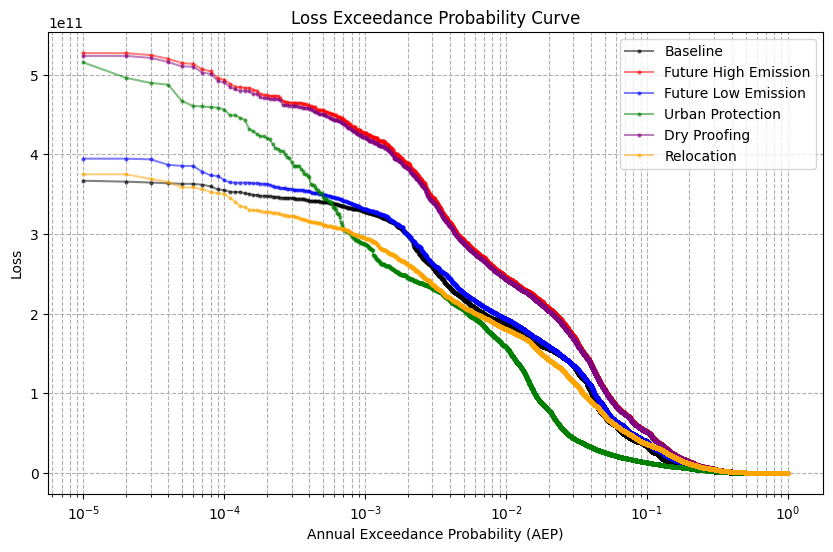

<Figure size 640x480 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.semilogx(aeps, baseline_sorted_losses, marker='o', linestyle='-', markersize=2, label='Baseline', alpha=0.5, color='black')
plt.semilogx(aeps, high_emission_sorted_losses, marker='o', linestyle='-', markersize=2, label='Future High Emission', alpha=0.5, color="red")
plt.semilogx(aeps, low_emission_sorted_losses, marker='o', linestyle='-', markersize=2, label='Future Low Emission', alpha=0.5, color="blue")
plt.semilogx(aeps, urban_protection_high_emission_sorted_losses, marker='o', linestyle='-', markersize=2, label='Urban Protection', alpha=0.5, color="green")
plt.semilogx(aeps, dry_proofing_high_emission_sorted_losses, marker='o', linestyle='-', markersize=2, label='Dry Proofing', alpha=0.5, color="purple")
plt.semilogx(aeps, relocation_high_emission_sorted_losses, marker='o', linestyle='-', markersize=2, label='Relocation', alpha=0.5, color="orange")
plt.xlabel('Annual Exceedance Probability (AEP)')
plt.ylabel('Loss')
plt.title('Loss Exceedance Probability Curve')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()
plt.savefig('loss_exceedance_probability_curve_gaus.png')

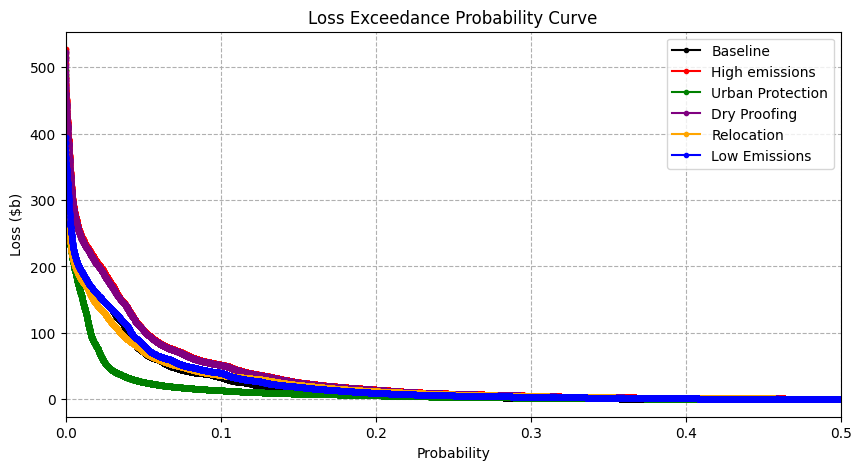

In [15]:
baseline_losses_b = baseline_sorted_losses/1000000000
high_emissions_losses_b = high_emission_sorted_losses/1000000000
low_emissions_losses_b = low_emission_sorted_losses/1000000000
urban_protection_losses_b = urban_protection_high_emission_sorted_losses/1000000000
dry_proofing_losses_b = dry_proofing_high_emission_sorted_losses/1000000000
relocation_losses_b = relocation_high_emission_sorted_losses/1000000000


plt.figure(figsize=(10, 5))
plt.plot(aeps, baseline_losses_b, marker='.', linestyle='-', label='Baseline', color='black')
plt.plot(aeps, high_emissions_losses_b, marker='.', linestyle='-', label='High emissions', color='red')
plt.plot(aeps, urban_protection_losses_b, marker='.', linestyle='-', label='Urban Protection', color='green')
plt.plot(aeps, dry_proofing_losses_b, marker='.', linestyle='-', label='Dry Proofing', color='purple')
plt.plot(aeps, relocation_losses_b, marker='.', linestyle='-', label='Relocation', color='orange')
plt.plot(aeps, low_emissions_losses_b, marker='.', linestyle='-', label='Low Emissions', color='blue')
# plt.xscale('log')
plt.ylabel('Loss ($b)')
plt.xlabel('Probability')
plt.xlim(0, 0.5)
#plt.ylim(0, 200)
plt.legend()
plt.title('Loss Exceedance Probability Curve')
plt.grid(True, which='both', ls='--')
plt.savefig('loss_exceedance_probability_curve_2_gaus.png')

In [16]:
def get_loss_for_rp(aeps, losses, rp):
    target_aep = 1 / rp
    # Find the closest AEP in the array to the target AEP and get the corresponding loss
    idx = (np.abs(aeps - target_aep)).argmin()
    return losses[idx]

In [17]:
get_loss_for_rp(aeps, relocation_high_emission_sorted_losses, 5000)

328141800898.00775

In [18]:
relocation_losses_b

array([375.12525493, 375.12525493, 369.43553103, ...,   0.        ,
         0.        ,   0.        ])

In [19]:
np.nanmean(relocation_losses_b)

12.969801444872571